In [12]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import Dataset

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [13]:
DEBUG = True
train_mp3 = pd.read_csv("../data/train.csv")
test_mp3 = pd.read_csv("../data/test.csv")

train_npy = pd.read_csv("../output/train_npy.csv")
test_npy = pd.read_csv("../output/test_npy.csv")

In [14]:
label = train_mp3["artist"]
X_train, X_val, y_train, y_val = train_test_split(train_mp3, label, test_size=0.2, random_state=42, stratify=label)
if DEBUG:
    X_train = X_train[~X_train['artist'].duplicated()]
    X_val = X_val[~X_val['artist'].duplicated()]
    y_train = y_train[~y_train.duplicated()]
    y_val = y_val[~y_val.duplicated()]

In [15]:
train_npy["is_train"] = np.nan

for mp3file in X_train["filename"]:
    train_npy["is_train"][ train_npy[train_npy['filename']== int(mp3file.split(".")[0]) ]["filename"].index.values.tolist() ] = 0

for mp3file in X_val["filename"]:
    train_npy["is_train"][ train_npy[train_npy['filename']== int(mp3file.split(".")[0]) ]["filename"].index.values.tolist() ] = 1
train_npy = train_npy.dropna(how='any')
if DEBUG:
    train_npy = train_npy[~train_npy['artist_id'].duplicated()]


/home/wsato/acoustic/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/wsato/acoustic/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/wsato/acoustic/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aft

In [17]:
class Load_Npy(object):
    def __init__(self):
        pass

    def __call__(self, path):

        mel_numpy = np.load(path)
        return mel_numpy

In [18]:
class WavDataset(Dataset):
    def __init__(self, path, filename ,label , transform = None):
        self.transform = transform

        self.path = path.values
        self.filename = filename.values
        self.label = label.values

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        out_data = self.path[idx]
        out_data_file = self.filename[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)
            out_list = [out_data, out_data_file]

        return out_list, out_label

In [19]:
X_train_npy = train_npy[ train_npy["is_train"] == 0]["npy_path"]
X_train_file = train_npy[ train_npy["is_train"] == 0]["filename"]
y_train = train_npy[ train_npy["is_train"] == 0]["artist_id"]

X_val_npy = train_npy[ train_npy["is_train"] == 1]["npy_path"]
X_val_file = train_npy[ train_npy["is_train"] == 1]["filename"]
y_val = train_npy[ train_npy["is_train"] == 1]["artist_id"]

In [21]:
load_npy = Load_Npy()
SR = 4410
N_FFT = 1024
HOP_LENGTH = 1024
TrainDs = WavDataset(X_train_npy,X_train_file ,y_train, load_npy)
ValidDs = WavDataset(X_val_npy,X_val_file ,y_val, load_npy)

In [22]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold

train_dataloader = torch.utils.data.DataLoader(TrainDs, shuffle = True, batch_size = 32)
valid_dataloader = torch.utils.data.DataLoader(ValidDs, shuffle = False, batch_size = 32)

In [23]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
import torch.nn.functional as F
import time
from sklearn.metrics import accuracy_score
import collections
%matplotlib inline

In [24]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [25]:
def check_cuda():
    _cuda = False
    if torch.cuda.is_available():
        _cuda = True
    return _cuda

is_cuda = check_cuda()

/home/wsato/acoustic/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [26]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, 64, 3), 
            nn.MaxPool2d(2), 
            nn.ReLU(), 
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3),    
            nn.MaxPool2d(2), 
            nn.ReLU() 
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), 
            nn.MaxPool2d(2), 
            nn.ReLU() 
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3), 
            nn.MaxPool2d(2), 
            nn.ReLU(), 
            nn.Dropout(0.2)
        )
        self.Linear1 = nn.Linear(512 * 6 * 6, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, 15)
        
        
    def forward(self, x):
        
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)

        return x    

In [27]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [28]:
### 訓練データはメルスペクトログラムは30秒ごとに区切った特徴量なので、1曲ごとに集計するためのdictを定義
x_train_mp3_dict = {}
x_val_mp3_dict = {}
label_train_mp3_dict = {}
label_val_mp3_dict = {}

### mp3ファイル名 : [ プレディクション結果のリスト ] の構成
for mp3 in X_train["filename"]:
    x_train_mp3_dict[mp3.split(".")[0] ] = []

for mp3 in X_val["filename"]:
    x_val_mp3_dict[mp3.split(".")[0] ] = []

for mp3 in X_train["filename"]:
    label_train_mp3_dict[mp3.split(".")[0] ] = []

for mp3 in X_val["filename"]:
    label_val_mp3_dict[mp3.split(".")[0] ] = []


epoch = 10

size = 0
sum_loss = 0
match_num = 0

size_valid = 0
sum_vaild_loss = 0
match_valid_num = 0

train_loss_value=[]
train_acc_value=[]
valid_loss_value=[]    
valid_acc_value=[]      

label_train = []
label_valid = []
train_music_acc = []
valid_music_acc = []

for i in tqdm( range(epoch) ):

    print( f"¥n------- epoch {i}-------\n")

    ### Trainフェーズ
    model.train()
    for data,label in train_dataloader:

        if is_cuda:
            inputs = data[0].float().cuda()
            label = label.long().cuda()
        else:
            inputs = data[0].float()
            label = label.long()

        inputs, label = Variable(inputs), Variable(label)

        optimizer.zero_grad()
        ops = model(inputs)

        loss = criterion(ops, label)
        sum_loss += loss
        
        loss.backward()
        optimizer.step()

        ### modelの最終層はlinerなので、１番大きい出力位置を参照することにより予測値とする
        _, predicted = torch.max(ops.data, 1)

        ### torch型をnumpyに変更
        predicted_numpy = predicted.to('cpu').detach().numpy().copy()
        label_ = label.to('cpu').detach().numpy().copy()

        ### 曲ごとにpredict結果を集計するためのループ　 30秒ごとの結果を対応するdictに追加していく
        for mp3, pred, artist_id in zip( data[1] , predicted_numpy ,label_) :

            mp3 = str(mp3.to('cpu').detach().numpy().copy())
            x_train_mp3_dict[mp3].append(pred)
            label_train_mp3_dict[mp3].append(artist_id)        
                
        size += label.size(0)
        match_num += (predicted == label).sum().item()

    ### trainループを終了し、30秒毎に予測した結果を集計する　
    for key,value in x_train_mp3_dict.items():
        c = collections.Counter( x_train_mp3_dict[key] )
        x_train_mp3_dict[key] = c.most_common()[0][0]

    ### 30秒ごとのlabelを集計する
    for key,value in label_train_mp3_dict.items():
        c = collections.Counter( label_train_mp3_dict[key] )
        label_train_mp3_dict[key] = c.most_common()[0][0]

    ### 30secごとに予測したloss acc
    train_loss_value.append(sum_loss)
    train_acc_value.append(match_num/size)

    ### 1曲にまとめたacc
    x_train_pred = list(x_train_mp3_dict.values() )
    label_train = list(label_train_mp3_dict.values() )
    
    ### epochごとの推移を確認. 1曲ごとのacc
    train_music_acc.append( accuracy_score( label_train, x_train_pred ) )

    ### 1epoch毎に初期化
    label_train = []
    x_train_pred = []
    
    for mp3 in X_train["filename"]:
        x_train_mp3_dict[mp3.split(".")[0] ] = []
    for mp3 in X_train["filename"]:
        label_train_mp3_dict[mp3.split(".")[0] ] = []

    size = 0
    sum_loss = 0
    match_num = 0
   
    ### validationフェーズ
    model.eval()
    for (data, label) in valid_dataloader:

        if is_cuda:
            inputs = data[0].float().cuda()
            label = label.long().cuda()
        else:
            inputs = data[0].float()
            label = label.long()

        inputs, label = Variable(inputs), Variable(label)

        optimizer.zero_grad()      
        ops = model(inputs)

        loss_valid = criterion(ops, label)
        sum_vaild_loss += loss_valid.item()

        _, predicted = torch.max(ops.data, 1)

        predicted_numpy = predicted.to('cpu').detach().numpy().copy()
        label_ = label.to('cpu').detach().numpy().copy() 

        for mp3, pred, artist_id in zip( data[1] , predicted_numpy ,label_) :
            
            mp3 = str(mp3.to('cpu').detach().numpy().copy())

  0%|          | 0/10 [00:00<?, ?it/s]

¥n------- epoch 0-------



  0%|          | 0/10 [00:00<?, ?it/s]


IndexError: list index out of range

In [18]:
valid_music_acc

[]

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

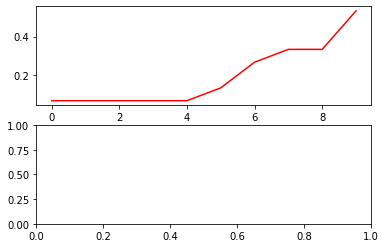

In [17]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(range(epoch), train_music_acc,color="red", label="train")
ax2.plot(range(epoch), valid_music_acc,color="blue", label="validation")

ax1.grid()
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("acc")
ax1.set_ylim(0, 1)

ax2.grid()
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("acc")
ax2.set_ylim(0, 1)

In [21]:
class TestDataset(Dataset):
    def __init__(self, path, filename, transform=None):
        self.transform = transform

        self.path = path.values
        self.filename = filename.values

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        out_data = self.path[idx]
        out_data_file = self.filename[idx]

        if self.transform:
            out_data = self.transform(out_data)
            out_list = [out_data, out_data_file]

        return out_list

In [23]:
X_test_npy = test_npy["npy_path"]
X_test_file = test_npy["filename"]

TestDs = TestDataset(X_test_npy,X_test_file , load_npy)
test_dataloader = torch.utils.data.DataLoader(TestDs, shuffle = False, batch_size = 32)

In [24]:
size = 0
match_num = 0

label_test = []

x_test_mp3_dict = {}

for mp3 in test_mp3["filename"]:
    x_test_mp3_dict[mp3.split(".")[0] ]  = []

for i, data in enumerate(tqdm(test_dataloader)):

    if is_cuda:
        inputs = data[0].float().cuda()
    else:
        inputs = data[0].float()
            
    output = model(inputs)
    _, predicted = torch.max(output.data, 1)

    predicted_numpy = predicted.to('cpu').detach().numpy().copy()
    mp3_name = data[1].to('cpu').detach().numpy().copy()

    for mp3, pred in zip( mp3_name, predicted_numpy ) :
        x_test_mp3_dict[str(mp3)].append(pred)

for key,value in x_test_mp3_dict.items():
    c = collections.Counter( x_test_mp3_dict[key])
    x_test_mp3_dict[key] = c.most_common()[0][0]

x_test_pred = list(x_test_mp3_dict.values() )

100%|██████████| 44/44 [00:16<00:00,  2.60it/s]


In [27]:
sample_df = pd.read_csv("../data/sample_submission.csv")

In [28]:
for i in range(len(sample_df)):
    key = str(sample_df["filename"][i].split(".")[0])
    sample_df.iloc[i,1] = x_test_mp3_dict[key]
sample_df.to_csv("../submission_tutorial.csv", index=False)